In [36]:
import pandas as pd
import graphlab as gl
import numpy as np
from IPython.core.display import display
from scipy.spatial.distance import cosine,euclidean,pdist,squareform,sqeuclidean
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import entropy
from numpy.linalg import norm
from jenks import jenks
from itertools import chain,tee, izip
from urllib import unquote_plus
from titlecase import titlecase
from itertools import combinations
import itertools
import seaborn
from scikits.bootstrap import ci

In [37]:
# GLOBAL PARAMS
SESSION_THRESHOLD = 99e99 # 30 minutes
MIN_LENGTH = 5 # Minimum number of scrobbles in a patch

In [38]:
### Load some example data
fi = "../testData/mylistening.txt"
#fi = "../testData/test_listening_data.tsv"
me = pd.read_table(fi,header=None,
            names=['user_id','item_id','artist_id','ts'],parse_dates=['ts']).sort_values(by='ts')
### Build artist_name:artist_idx dict from 
artist_idx = {}
for line in open('../GenreModeling/data/vocab_idx'):
    line = line.strip().split('\t')
    artist_idx[line[0]] = int(line[1])
### Load artist feature matrix
features = np.load('../GenreModeling/data/features/lda_artists/features_190.npy')

In [39]:
### Build artist_id:artist_name and artist_name:artist_idx dicts from database data
artist_ids = {}
artist_names = {}
for line in open('../GenreModeling/data/artist_ids'):
    line = line.strip().split('\t')
    artist_ids[int(line[0])] = line[1]
    artist_names[line[1]] = int(line[0])
    
# Lookup function to get features for a given artist ID or artist name
def get_features(aid=None,artist_name=None):
    if artist_name is None:
        artist_name = artist_ids.get(aid)
        if not artist_name: 
            return np.repeat(np.nan,features.shape[1])
    return features[artist_idx[artist_name]]

# Function for Jensen Shannon Distance (Sqrt of Jensen Shannon Divergence)
def JSD(P, Q):
    if np.all(np.isnan(P)) or np.all(np.isnan(Q)):
        return np.nan
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return np.sqrt(np.clip(0.5 * (entropy(_P, _M) + entropy(_Q, _M)),0,1))

# Function to calculate distance between any two artists 
def calc_sim(artist1,artist2,metric='cosine'):
    if np.isnan(artist1) or np.isnan(artist2):
        return np.nan
    if artist1==artist2:
        return 0.0
    features1 = get_features(artist1)
    if np.all(np.isnan(features1)): return np.nan
    features2 = get_features(artist2)
    if np.all(np.isnan(features2)): return np.nan
    if metric == 'JSD':
        return JSD(features1,features2)
    elif metric == 'cosine':
        return cosine(features1,features2)
    elif metric == 'euclidean':
        return sqeuclidean(features1,features2)

# for proper formatting of artist names
def formatter(s):
    if s:
        try: return titlecase(unquote_plus(s))
        except: return s
    return 'UNKNOWN'

# Just a clean format for presenting example dataframes 
def pres_format(input_df):
    df = input_df.copy()
    df = df[['ts','artist_name','dist']].reset_index(drop=True)
    df.columns = ['timestamp','artist','distance']
    df['artist'] = df['artist'].apply(formatter)
#    df['previous artist'] = df['previous artist'].apply(formatter)
    return df

In [40]:
# All pre-formatting of data
new = me.copy()
new['before'] = new.shift(1)['artist_id']
new['td'] = new['ts']-new.shift(1)['ts']
new['td'] = new['td'].astype(int) / 10**9
new['artist_name'] = new.apply(lambda row: artist_ids.get(row['artist_id']),axis=1)
new['before_name'] = new.shift(1)['artist_name']
new = new[['ts','artist_id','before','td','artist_name','before_name']]
new['dist'] = new.apply(lambda row: calc_sim(row['artist_id'],row['before']),axis=1)
new['features'] = new['artist_name'].apply(lambda a: get_features(artist_name=a))
new = new.reset_index(drop=True)

In [41]:
### Add session index information
session_idx = 0
session_indices = []
for val in new['td']>=SESSION_THRESHOLD:
    if val:
        session_idx +=1
    session_indices.append(session_idx)
new['session'] = session_indices

### deletes session shorter than MIN_LENGTH
#session_counts = new['session'].value_counts()
#new = new[new['session'].isin(session_counts[session_counts>=MIN_LENGTH].index)]

In [42]:
### Get top artist info

top_artists = new['artist_id'].value_counts().reset_index()
top_artists.columns = ['artist_id','scrobbles']
top_artists['artist_name'] = top_artists['artist_id'].apply(lambda x: artist_ids.get(x))


In [43]:
### If we want to remove sessions with unknown artists (but let's not for now)
def remove_sessions_with_unknowns(df):
    if df['artist_name'].hasnans:
        return None
    else:
        return df
#new = new.groupby('session').apply(remove_sessions_with_unknowns).reset_index(drop=True)


In [44]:
### Add patch index information
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return izip(a, b)

s=20
dist_thresh = 0.2

def patch_segmenter(df,shuffle=True):
    l = df['artist_id']
    indices = list(np.array([len(list(v)) for g,v in itertools.groupby(l)][:-1]).cumsum())
    new_indices = []

    for b in indices:
        try:
            dist = cosine(df.iloc[b]['features'],df.iloc[b-1]['features'])
        except ValueError:
            dist = 1.
        #print b,test.iloc[b-1]['artist_name'],test.iloc[b]['artist_name'],dist
        if dist >= dist_thresh:
            new_indices.append(b)
    
    
    if new_indices:

        last_patch = False
        final_indices = []
        for i,(a,b) in enumerate(pairwise([0]+new_indices+[len(df)])):
            if b-a>=MIN_LENGTH:
                final_indices.append(a)
                last_patch = True
            else:
                if last_patch:
                    final_indices.append(a)
                last_patch = False
        
        return final_indices,new_indices
    return new_indices,new_indices
        
test = new.copy()
indices_shuffle = np.zeros(len(test),dtype=int)
indices_simple = np.zeros(len(test),dtype=int)
offset_shuffle = 0
idx_shuffle=0
offset_simple = 0
idx_simple=0

for session in test.groupby('session'):
    result_shuffle,result_simple = patch_segmenter(session[1])
    n=len(session[1])
    
    if len(result_shuffle)==0:
        indices_shuffle[offset_shuffle:offset_shuffle+n] = idx_shuffle
        idx_shuffle+=1
    else:
        indices_shuffle[offset_shuffle:offset_shuffle+result_shuffle[0]] = idx_shuffle
        idx_shuffle+=1
        for v, w in pairwise(result_shuffle):
            indices_shuffle[offset_shuffle+v:offset_shuffle+w] = idx_shuffle
            idx_shuffle+=1
        indices_shuffle[offset_shuffle+result_shuffle[-1]:offset_shuffle+result_shuffle[-1]+n] = idx_shuffle
        idx_shuffle+=1
    offset_shuffle += n

    if len(result_simple)==0:
        indices_simple[offset_simple:offset_simple+n] = idx_simple
        idx_simple+=1
    else:
        indices_simple[offset_simple:offset_simple+result_simple[0]] = idx_simple
        idx_simple+=1
        for v, w in pairwise(result_simple):
            indices_simple[offset_simple+v:offset_simple+w] = idx_simple
            idx_simple+=1
        indices_simple[offset_simple+result_simple[-1]:offset_simple+result_simple[-1]+n] = idx_simple
        idx_simple+=1
    offset_simple += n


    
if result_shuffle:
    indices_shuffle[offset_shuffle+result_shuffle[-1]:] = idx_shuffle
else:
    indices_shuffle[offset_shuffle:] = idx_shuffle
    
if result_simple:
    indices_simple[offset_simple+result_simple[-1]:] = idx_simple
else:
    indices_simple[offset_simple:] = idx_simple

test['patch_idx_shuffle'] = indices_shuffle
test['patch_idx_simple'] = indices_simple

In [45]:
# add artist block info
### https://stackoverflow.com/questions/14358567/finding-consecutive-segments-in-a-pandas-data-frame

test['block'] = (test['artist_id'].shift(1) != test['artist_id']).astype(int).cumsum()


In [48]:
test[test['session']==0]

,ts,artist_id,before,td,artist_name,before_name,dist,features,session,patch_idx_shuffle,patch_idx_simple,block
0,2007-02-24 22:54:28,405,NaN,-9.223372e+09,queens+of+the+stone+age,NaN,NaN,"[4.91829124712e-08, 9.83658249424e-07, 1.05153...",0,0,0,1
1,2007-02-24 22:59:07,11337,405.0,2.790000e+02,lupe+fiasco,queens+of+the+stone+age,0.986968,"[0.00206053967627, 0.00718731389527, 5.2858440...",0,0,1,2
2,2007-02-24 23:01:54,4536,11337.0,1.670000e+02,black+eyed+peas,lupe+fiasco,0.765355,"[0.0252498142872, 0.00246156047485, 0.00116852...",0,0,2,3
3,2007-02-25 01:55:39,42105,4536.0,1.042500e+04,aesop+rock,black+eyed+peas,0.925810,"[3.00600377109e-07, 3.57113248006e-05, 3.00600...",0,0,3,4
4,2007-02-25 02:00:36,3014,42105.0,2.970000e+02,at+the+drive-in,aesop+rock,0.830164,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0,0,4,5
5,2007-02-25 02:03:25,1996,3014.0,1.690000e+02,the+beatles,at+the+drive-in,0.846672,"[0.0028117453458, 0.00228912284443, 0.00037457...",0,0,5,6
6,2007-02-25 02:05:00,1328,1996.0,9.500000e+01,stone+temple+pilots,the+beatles,0.311480,"[7.74341252278e-06, 0.00108192191675, 2.199833...",0,0,6,7
7,2007-02-25 02:09:16,7432,1328.0,2.560000e+02,fatboy+slim,stone+temple+pilots,0.682434,"[0.000598386557643, 0.000367025536486, 0.00312...",0,0,7,8
8,2007-02-25 02:12:30,405,7432.0,1.940000e+02,queens+of+the+stone+age,fatboy+slim,0.668268,"[4.91829124712e-08, 9.83658249424e-07, 1.05153...",0,0,8,9
9,2007-02-25 02:15:22,3875,405.0,1.720000e+02,sonic+youth,queens+of+the+stone+age,0.695976,"[8.45810708387e-06, 1.9637518186e-05, 7.354875...",0,0,9,10


In [13]:
# patch summary data methods

def patch_stats(df,agg_stats=True):
    first = df.iloc[0]
    n = len(df)
    start = first['ts']
    if agg_stats:
        artists = df['artist_id'].values
        if (n==1) or (len(df['artist_id'].unique())==1):
            diversity = 0.
            centroid = first['features']
        else:
            #diversity = (len(df['artist_id'].unique())/float(len(df))) * df['dist'][1:].mean()
            features = np.array([get_features(i) for i in df['artist_id']])
            centroid = np.nanmean(features,axis=0)
            diversity = np.nanmean(pdist(features,metric='cosine'))
            #diversity = (((len(df['artist_id'].unique())-1)/float(len(df)-1)) + df['dist'][1:].mean())/2.
            #centroid = np.nanmean([get_features(i) for i in df['artist_id']],axis=0)
        
        return pd.Series({'diversity':diversity,'centroid':centroid,'start_ts':start,'n':n,'artists':artists})
    else:
        artist = first['artist_id']
        return pd.Series({'start_ts':start,'n':n,'artist_idx':artist})
    

basis = 'patch_idx_shuffle'
#basis = 'block'
if basis=='block': agg_stats=False
else: agg_stats = True
result = test.groupby(basis).apply(patch_stats,agg_stats)#.reset_index(level=1,drop=True)
result['start_idx'] = result['n'].cumsum().shift(1).fillna(0).astype(int)
    



/Users/jaredlorince/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [ ]:
### Session clustering
result['prev_centroid'] = result['centroid'].shift(1)
def centroid_dist(row):
    if np.any(np.isnan(row['centroid'])) or np.any(np.isnan(row['prev_centroid'])):
        return np.nan
    else:
        return cosine(row['centroid'],row['prev_centroid'])
result['dist'] = result.apply(centroid_dist,axis=1)
result.head()
#seaborn.distplot(result['dist'][result['dist']>0])
filtered = result[result.apply(lambda row: ~np.all(row['centroid']==row['prev_centroid']),axis=1)]
seaborn.distplot(filtered['dist'].dropna())
#result[result['dist']<0.3]

In [ ]:
brks2 = jenks(result[result['n']>=5]['diversity'].dropna(),2)
brks3 = jenks(result[result['n']>=5]['diversity'].dropna(),3)
print brks2,brks3
#ax = seaborn.distplot(result[result['n']>=5]['diversity'].dropna(),norm_hist=False,bins=25)
ax = seaborn.distplot(result[(result['n']>=5)&(result['diversity']>0)]['diversity'].dropna(),bins=25)
# ax.axvline(brks2[1],c='k',ls='--')
# ax.axvline(brks3[1],c='r',ls='--')
# ax.axvline(brks3[2],c='r',ls='--')
#ax.axvline(brks[2],c='k',ls='--')
#ax.set_yscale('log')
ax.set_xlim(0,1);


In [ ]:
from scipy.spatial.distance import sqeuclidean
new['dist_euc'] = new.apply(lambda row: calc_sim(row['artist_id'],row['before'],metric='euclidean'),axis=1)


In [ ]:
new['dist_euc'].describe()

In [ ]:
#seaborn.jointplot(x='dist',y='dist_euc',data=new,kind='kde')
from scipy.stats import pearsonr,spearmanr
print pearsonr(new['dist'].dropna(),new['dist_euc'].dropna())
print spearmanr(new['dist'].dropna(),new['dist_euc'].dropna())


In [ ]:
#seaborn.distplot(new['dist'][new['dist']>0],norm_hist=False)
seaborn.distplot(new['dist'].dropna())

In [ ]:
features.shape

In [ ]:
def calc_dist(idx_1,idx_2,metric='cosine'):
    if np.isnan(idx_1) or np.isnan(idx_2):
        return np.nan
    features1 = features[idx_1]
    features2 = features[idx_2]

    if metric == 'JSD':
        return self.JSD(features1,features2)
    elif metric == 'cosine':
        return cosine(features1,features2)
    elif metric == 'euclidean':
        return euclidean(features1,features2)

randhop = pd.DataFrame({'a':np.random.randint(0,112312,1000000)})
randhop['prev'] = randhop['a'].shift(1)
randhop['dist'] = randhop.apply(lambda row: calc_dist(row['a'],row['prev']),axis=1)
#seaborn.distplot(randhop['dist'].dropna(),kde=False,norm_hist=False)

In [ ]:
bins = np.arange(0,1.01,0.01)
vals = np.histogram(randhop['dist'],bins=bins)[0]

In [ ]:
np.save('../testData/1Mrandhops.npy',vals/float(vals.sum()))
#randhop.describe()


In [ ]:
#seaborn.distplot(randhop['dist'].dropna(),kde=False,norm_hist=False)
bins = np.arange(0,1.01,0.05)
vals = np.histogram(new['dist'][new['dist']>0],bins=bins)[0]
vals = vals/float(vals.sum())
vals2 = np.histogram(randhop['dist'].dropna(),bins=bins)[0]
vals2/float(vals2.sum());

In [18]:
result = []
blocks = test[['artist_id','block']].groupby('block').first()
for i in xrange(len(blocks)-100):
    first = blocks['artist_id'].iloc[i]
    result.append(np.array(blocks['artist_id'][i+1:i+101].apply(lambda val: calc_sim(val,first))))
    

In [53]:
blocks['artist_id'].iloc[len(blocks)-99:].shape

(99,)

In [28]:
def bootstrap(data, num_samples, statistic, alpha=0.05):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = np.random.randint(0, n, (num_samples, n))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])


CPU times: user 4.93 s, sys: 168 ms, total: 5.1 s
Wall time: 5.1 s
CPU times: user 7.65 s, sys: 2.68 s, total: 10.3 s
Wall time: 10.3 s


In [33]:
result_arr = np.vstack(result)
ci_lower = []
ci_upper = []
for i in xrange(result_arr.shape[1]):
    #lower,upper = ci(result_arr[:,i],statfunction=np.nanmean,n_samples=1000)
    lower,upper = bootstrap(result_arr[:,i],num_samples=1000,statistic=np.nanmean)
    ci_lower.append(lower)
    ci_upper.append(upper)

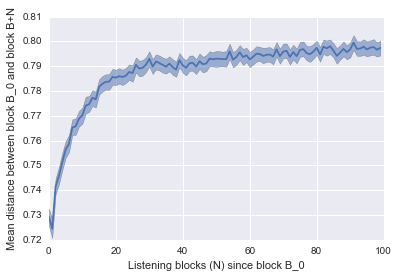

In [35]:
fig,ax = plt.subplots(1,1)
ax.plot(np.nanmean(result_arr,0))
ax.fill_between(xrange(100),ci_lower,ci_upper,alpha=0.5)
ax.set_xlabel('Listening blocks (N) since block B_0')
ax.set_ylabel('Mean distance between block B_0 and block B+N')

/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':


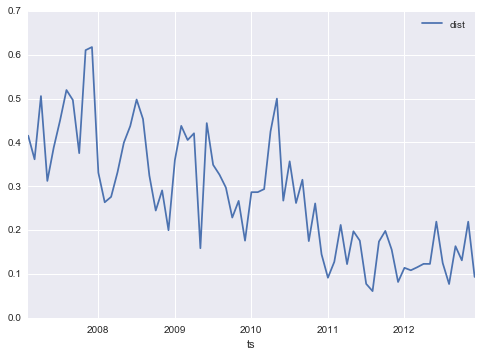

In [114]:
new[['ts','dist']].set_index('ts').resample('M',how='mean').plot()

In [55]:
test['session'].unique()

array([0])